In [1]:
import numpy as np
from matplotlib import pyplot as plt

import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import pymc3 as pm

# Gamma Ray Bursts

In the 1960's the US began the [Vela satellite program](https://en.wikipedia.org/wiki/Vela_(satellite)), sending gamma ray detectors into space with the intention of monitoring the USSR for secret nuclear tests violating the Nuclear Test Ban Treaty during the cold war (image credit:[Los Alamos National Laboratory](https://en.wikipedia.org/wiki/Vela_satellite#/media/File:Vela5b.jpg)).

<img src="https://imagine.gsfc.nasa.gov/Images/vela5b/vela5b_5.gif" width="250" alt="Vela"/>

These satellites picked up numerous bursts of gamma rays, but they were unlike anything seen during nuclear testing.

<img src="https://news.psu.edu/sites/default/files/styles/photo_gallery_large/public/Neutron_Star_Merger_Still_2.jpg" width="500" alt="GRB"/>

These bursts turned out to be cosmic, not terrestrial, in origin.  Know referred to as gamma ray bursts (GRBs), they are the brightest electromagnetic events known to happen in the universe (image credit:[NASA](https://fermi.gsfc.nasa.gov/)).

NASA's most recent mission to study these bursts is the Fermi Gamma Ray Space Telescope, which launched in 2008 (image credit:[NASA](https://www.nasa.gov/content/fermi/overview)).

<img src="https://www.nasa.gov/sites/default/files/fermi.jpg" alt="Fermi" width="500"/>

To date, Fermi has detected more than 2000 GRBs.  In this project we're going to look at its observations of these GRBs, particularly how long the bursts last, to develop a better understanding of what these GRBs are.

## Load Data

I've provided data downloaded directly from NASA's [Fermi GBM Burst Catalog](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermigbrst.html).  There are lots more data available for these events, but we're going to focus on the distribution of `T90`, the time taken to accumulate 90% of the burst fluence starting at the 5% fluence level (fluence is the radiant energy received by a surface -- the gamma ray detectors in this case -- per unit area, with units $\mathrm{J}/\mathrm{m}^2$).

In [2]:
# Lets establish a data type.  We'll be storing event names and T90 measurements
dtype=[('name', 'S12'), ('T90', np.float64)]
data = np.genfromtxt('Fermi_GRBs.txt', usecols=(1,4), skip_header=5, delimiter='|', dtype=dtype)

print(data)
print("{} events read.".format(len(data)))

[(b'GRB140323433', 111.426) (b'GRB100325246',   8.192)
 (b'GRB100507577',  44.033) ... (b'GRB121117018', 331.782)
 (b'GRB160609690',   1.6  ) (b'GRB090222179',  17.408)]
2210 events read.


There is one burst without a `T90` measurement, so let's remove it from our dataset.

In [3]:
data = data[~np.isnan(data['T90'])]
print("{} events left.".format(len(data)))

2209 events left.


# Distribution of `T90`

Now let's take a look at the distribution of `T90`.

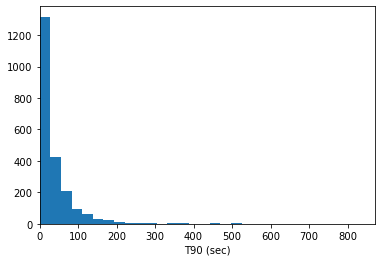

In [4]:
# Store T90 values in a dedicated array for convenience
T90 = data['T90']

plt.hist(T90, bins=30)

plt.xlabel('T90 (sec)')
plt.xlim(xmin=0);

It's hard to see any detail here, so let's use a log scale.

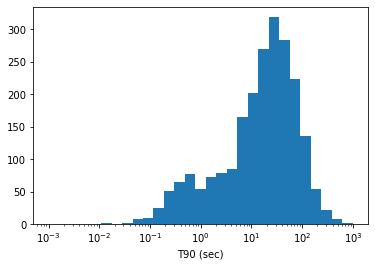

In [5]:
fig, ax = plt.subplots()

nbins = 30
bins = np.logspace(-3, 3, nbins)
plt.hist(data['T90'], bins=bins)
plt.xlabel('T90 (sec)')
ax.set_xscale('log');

This looks kind of Gaussian...ish.  Let's try modeling it with a normal distribution.

Since this is $\log_{10} (\mathrm{T90})$ we should technically be using a log-Normal distribution, but since we've already used standard Gaussian mixture models we'll just analyze the $\log$ of the data.

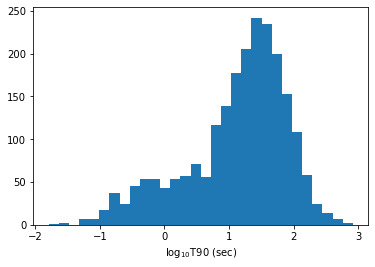

In [6]:
logT90 = np.log10(data['T90'])
plt.hist(logT90, bins=30)
plt.xlabel('$\log_{10}\mathrm{T90}$ (sec)');

In [7]:
def GaussianDist(theta, mu, sigma):
    return (np.e**(-.5 * ((theta - mu)/sigma)**2))/(sigma*np.sqrt(2 * np.pi))

# Results

Point totals for each section (481/581) are provided.

## Gaussian model (45/25)

Using the `logT90` dataset defined above, build a `PyMC3` Gaussian distribution model.  Describe each component of your model, describe the priors you use and why, identify which component is the likelihood.

In [8]:
# Gaussian model here (15/10)

In [9]:
with pm.Model() as Gaussian:
    # priors
    # The mean is going to be somewhere in the data so I made it equally likely everywhere
    mu = pm.Uniform('mu', lower = min(logT90), upper = max(logT90)) 
    # The SD is going to be close to one just by inspection so I made the prior exponential as to not exclude any larger values completely
    sigma = pm.Exponential('sigma', 1)
    
    # Likelihood
    dist = pm.Normal('Log of Time', mu = mu, sigma = sigma, observed = logT90)

Sample the posterior for this model.  Show your traces and discuss them.  Did you get good sampling?  Are you sure your priors aren't too restrictive?

In [10]:
# Trace plot, etc. and discussion here (10/5)

In [11]:
with Gaussian:
    start = pm.find_MAP()
    trace1 = pm.sample(5000, start=start)

logp = -2,598.3, ||grad|| = 6.8212e-06: 100%|██████████| 12/12 [00:00<00:00, 507.40it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]
Sampling chain 1, 0 divergences: 100%|██████████| 5500/5500 [00:06<00:00, 914.59it/s]


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,1.124,0.017,1.092,1.154,0.0,0.0,8849.0,8843.0,8843.0,7131.0,1.0
sigma,0.784,0.012,0.762,0.806,0.0,0.0,9013.0,9013.0,9028.0,6879.0,1.0


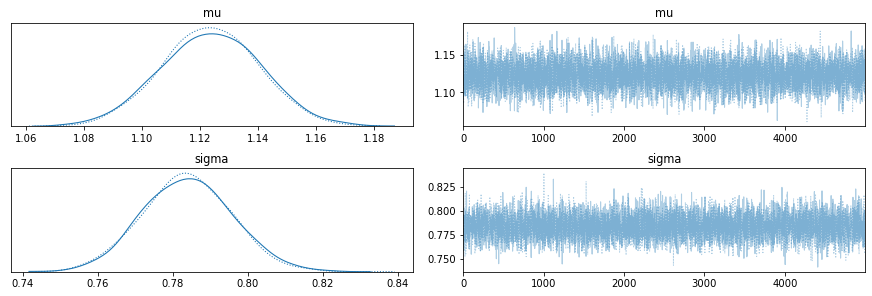

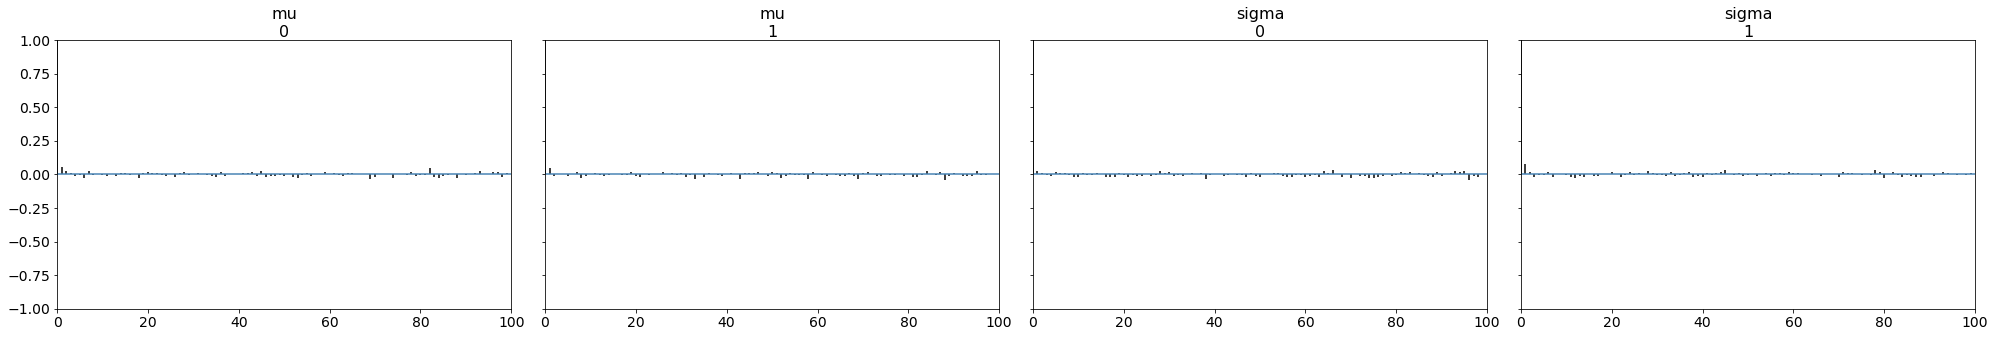

In [42]:
pm.traceplot(trace1);
pm.autocorrplot(trace1);
pm.summary(trace1)

#### The traces look like they've explored parameter space pretty well with some room for improvement, but overall they're good. The auto-correlation is essentially zero for the entirety of trace which is a good indication that we sampled the data well enough. The priors are also non-restrictive and we can infer this due to the fact that neither of the priors look like their corresponding posteriors, insinuating that the data far outweighs the priors. I also re-ran the model with different priors and got the same results, indicating the priors aren't strong enough to influence the data, which is what we want.

Show the marginal posterior estimates for the parameters in your model.  What have we learned?

In [13]:
# Marginal posterior plots here (10/5)

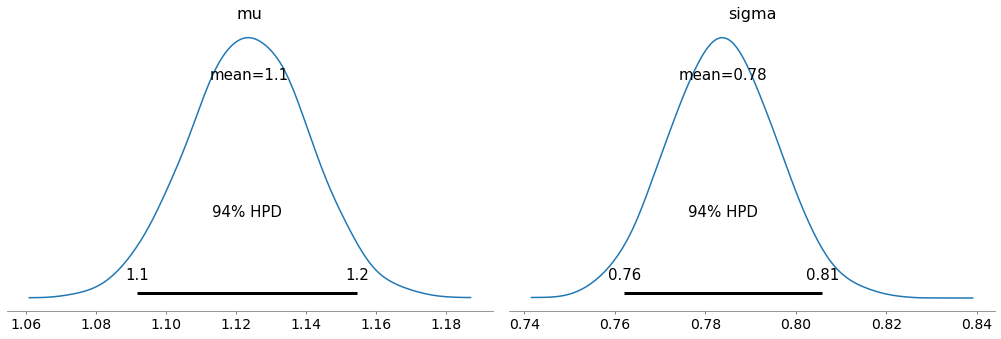

In [14]:
pm.plot_posterior(trace1);

##### We've learned that the model has sampled the posterior well enough and that the data has small standard deviations on mu and sigma

How well does your model fit the data?  You can show this by either plotting the posterior constraints for your model with the data, or doing posterior predictive checks and simulating data from your constrained model and comparing to the actual data.

In [15]:
# Compare to data here (10/5)

/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


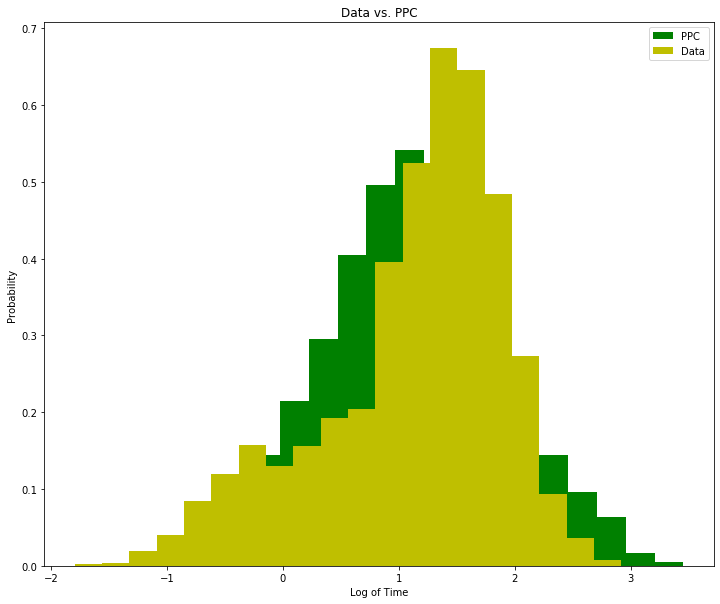

In [16]:
ppc = pm.sample_posterior_predictive(trace1, samples = 1, model = Gaussian)
plt.figure(figsize = (12,10))
plt.hist(ppc['Log of Time'][0], bins = 20, color = 'g', density = True);
plt.hist(logT90, bins = 20, color = 'y', density = True);
plt.xlabel('Log of Time');
plt.ylabel('Probability');
plt.title('Data vs. PPC');
plt.legend(['PPC', 'Data']);

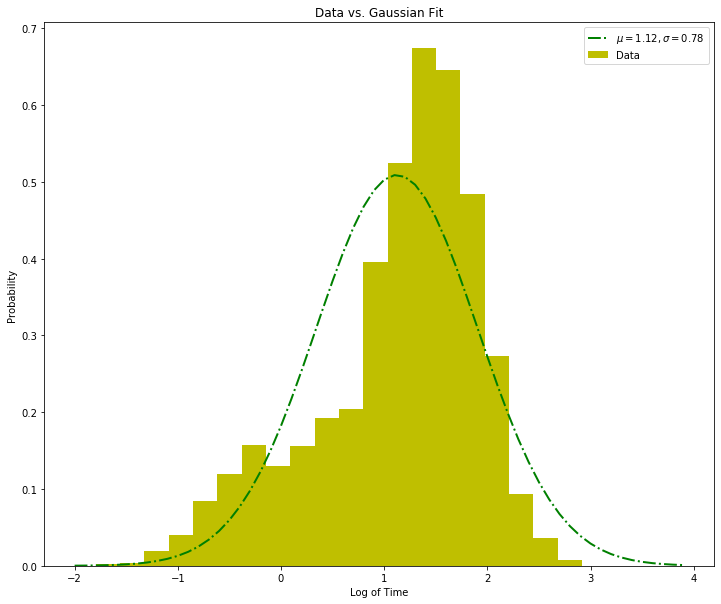

In [17]:
theta = np.arange(-2, 4, .1)
mu = trace1['mu'].mean()
sd = trace1['sigma'].mean()
plt.figure(figsize = (12,10))
plt.hist(logT90, bins = 20, color = 'y', density = True, zorder = 0);
plt.plot(theta, GaussianDist(theta, mu, sd), color = 'g', zorder = 10, linestyle = "-.", linewidth = 2);
plt.xlabel('Log of Time');
plt.ylabel('Probability');
plt.title('Data vs. Gaussian Fit');
plt.legend(["$\mu = {}, \sigma = {}$".format(float(str(mu)[:4]), float(str(sd)[:4])), 'Data']);

In [18]:
pm.rhat(trace1)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 1.001
    sigma    float64 1.001

#### While the parameters aren't widely varied, the model obiously looks like it doesn't fit the data super well. Using the PPC, we can also see that there's a large portion of data that the PPC predicts that is largely missing, as well as data that happens smore often than the PPC and the model predict.

## Gaussian mixture model (55/55)

Now lets use a 2-component Gaussian mixture model to better understand the data. Build a 2-component *marginalized* Gaussian mixture model (i.e., no latent categorical variables). Describe each component of your model, describe the priors you use and why, identify which component is the likelihood.

In [19]:
# Gaussian mixture model here (15/15)
k = 2

with pm.Model() as Mix:
    # priors
    # weights
    w = pm.Dirichlet('w', a = np.ones(k), shape = k, testval = [0.5, 0.5])

    # means
    means = pm.Uniform('means', min(logT90), max(logT90), shape = k, testval = [0.5, 1.5])

    # sigmas
    sd = pm.Exponential('sd', 1, shape = k, testval = [1, 1])
    
    # avoid the exchange symmetry to make sampling easier
    if k > 1:
        switchs = [pm.math.switch(means[c] - means[c-1] < 0, -np.inf, 0) for c in range(1, k)]
        order_means_potential = pm.Potential('order_means_potential', pm.math.sum(switchs))
    # Likelihood
    mixture = pm.NormalMixture('obs', w, mu = means, sd = sd, observed = logT90)

Sample the posterior for this model.  Show your traces and discuss them.  Did you get good sampling?  Are you sure your priors aren't too restrictive?

In [20]:
# Trace plots and discussion here (10/10)

In [21]:
with Mix:
    start = pm.find_MAP()
    trace2 = pm.sample(10000, start=start)

logp = -2,356.3, ||grad|| = 68.581: 100%|██████████| 21/21 [00:00<00:00, 381.13it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, w]
Sampling chain 1, 0 divergences: 100%|██████████| 10500/10500 [01:19<00:00, 132.12it/s]


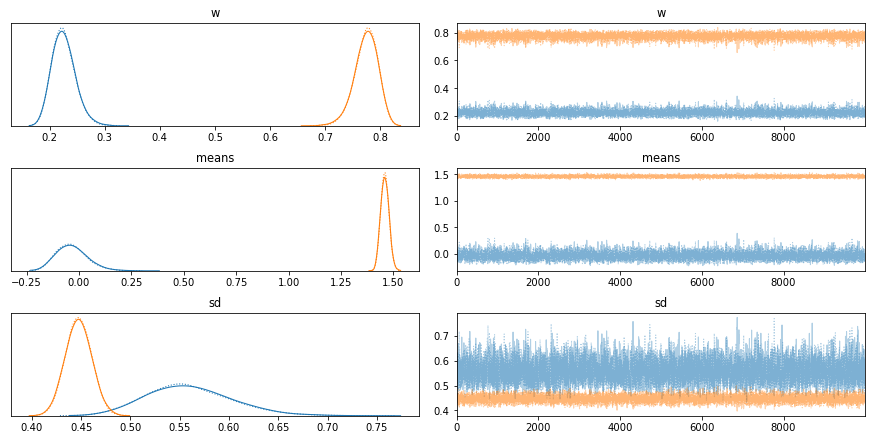

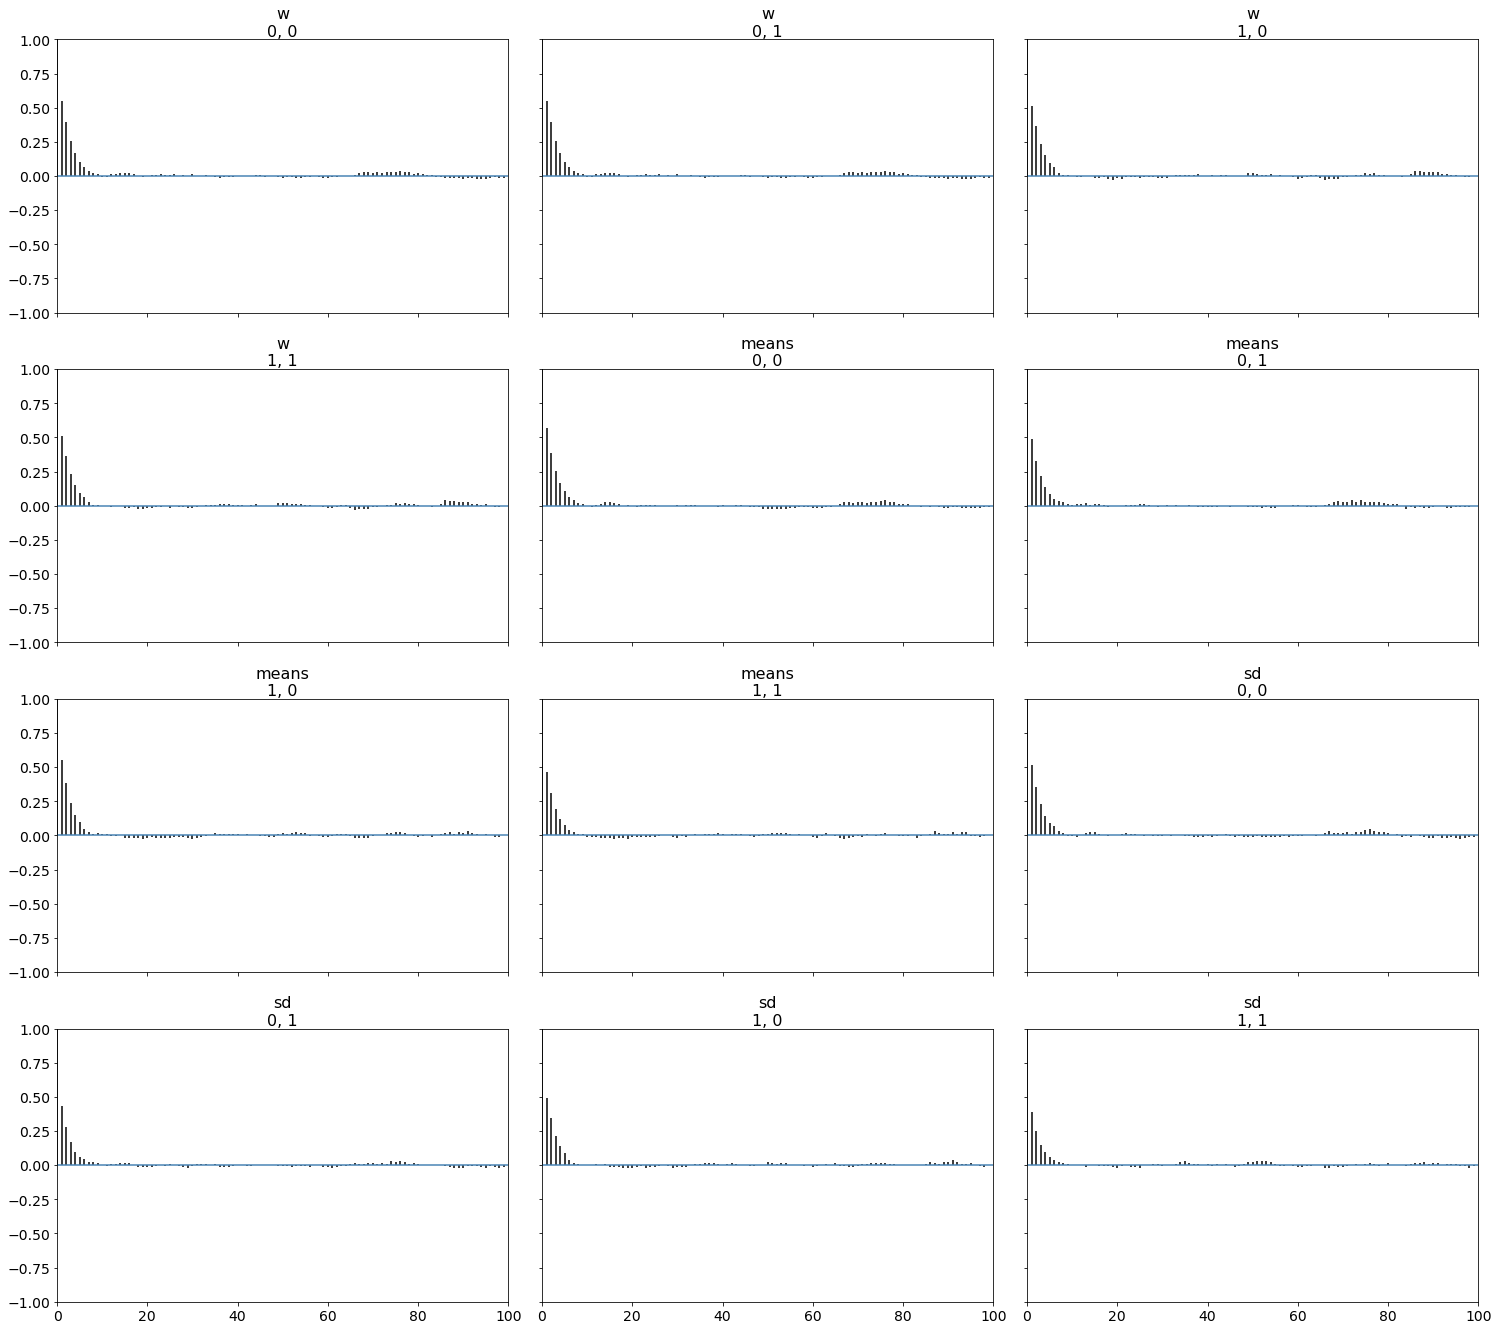

In [22]:
pm.traceplot(trace2);
pm.autocorrplot(trace2);

#### The traces have definitely sampled parameter space well. There's virtually no wobble on them for both of the sub distributions. The auto-correlation is also virtually zero by the time it counts. The priors are also not restrictive at all for the same reasons as previously described. 

In [23]:
# Marginal posterior plots here (10/10)

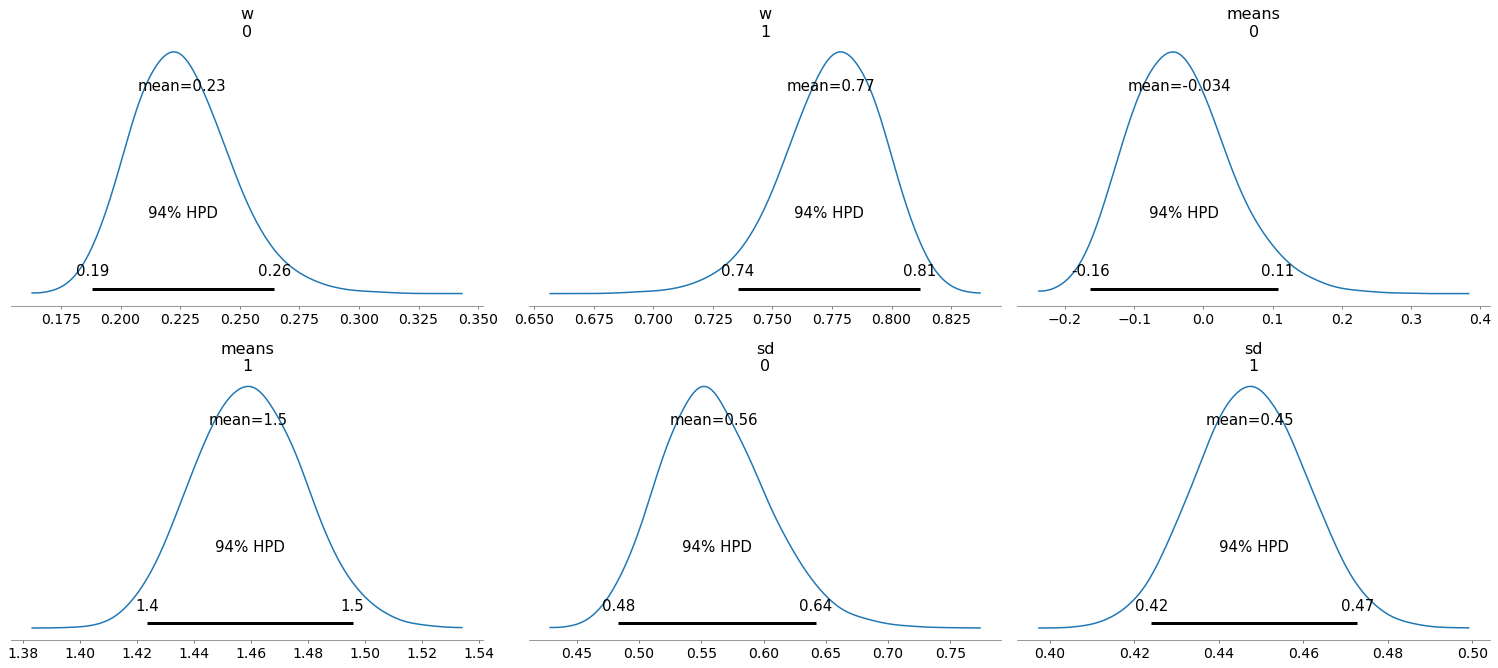

In [24]:
pm.plot_posterior(trace2);

Show the marginal posterior estimates for the parameters in your model.  What have we learned?

#### We can see that the traces definitely sampled the posterior well because of the small standard deviations on each variable

How well does your model fit the data.  You can show this by either plotting the posterior constraints for your model with the data, or doing posterior predictive checks and simulating data from your constrained model and comparing to the actual data.  How is your Gaussian mixture model performing compared to single Gaussian model above?

In [25]:
# Compare to data here (10/10)

In [26]:
pm.summary(trace2)
pm.rhat(trace2)

<xarray.Dataset>
Dimensions:      (means_dim_0: 2, sd_dim_0: 2, w_dim_0: 2)
Coordinates:
  * w_dim_0      (w_dim_0) int64 0 1
  * means_dim_0  (means_dim_0) int64 0 1
  * sd_dim_0     (sd_dim_0) int64 0 1
Data variables:
    w            (w_dim_0) float64 1.0 1.0
    means        (means_dim_0) float64 1.0 1.0
    sd           (sd_dim_0) float64 1.0 1.0

In [27]:
ppc2 = pm.sample_posterior_predictive(trace2, samples = 1, model = Mix)

/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


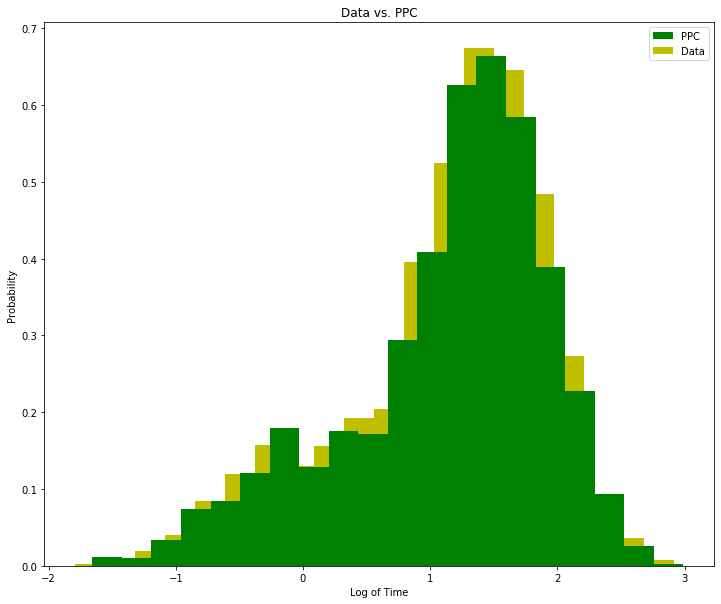

In [28]:
w1, w2, mu1, mu2, sd1, sd2 = pm.summary(trace2)['mean'][:]
plt.figure(figsize = (12,10));
plt.hist(ppc2['obs'][0], bins = 20, color = 'g', zorder = 10, density = True);
plt.hist(logT90, bins = 20, color = 'y', density = True);
plt.xlabel('Log of Time');
plt.ylabel('Probability');
plt.title('Data vs. PPC');
plt.legend(['PPC', 'Data']);

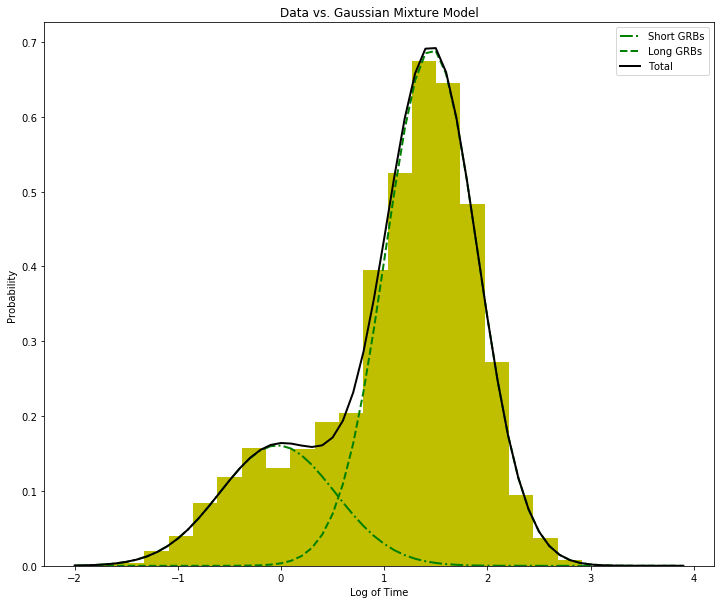

In [29]:
plt.figure(figsize = (12,10));
plt.title("GRB Mode Distribution")
plt.plot(theta, w1 * GaussianDist(theta, mu1, sd1), color = 'g', zorder = 5, linewidth = 2, linestyle = "-.")
plt.plot(theta, w2 * GaussianDist(theta, mu2, sd2), color = 'g', zorder = 5, linewidth = 2, linestyle = "--")
plt.plot(theta, w1 * GaussianDist(theta, mu1, sd1) + w2 * GaussianDist(theta, mu2, sd2), color = 'k', zorder = 10, linewidth = 2)
plt.hist(logT90, bins = 20, color = 'y', density = True);
plt.xlabel('Log of Time');
plt.ylabel('Probability');
plt.title('Data vs. Gaussian Mixture Model');
plt.legend(labels = ('Short GRBs', 'Long GRBs', 'Total'));

#### As seen in the cells above, the gaussian mixture model fits the data way better than the single gaussian did. This is evident in the above plot as the black curve, the sum of the two gaussians that were found with the model, follows the data tightly. The auto-correlation is also close to zero for the majority of the time and the r hat values are 1 to at least the thousandths place. The PPC also fits the data very well and there is little to no over/underestimation.

The two subpopulations you have constrained here are thought to arise from very different processes.  The short-duration population, creatively named *short gamma ray bursts*, are believed to be from compact binary mergers with neutron stars (GW170817/GRB170817A is the first confirmation of this).  The *long gamma ray bursts* are instead the death of massive stars, and are often associated with core-collapse supernovae.

From your posterior estimates above, what can you say about the fraction of detected GRBs that are short GRBs?

In [30]:
# Posterior estimate for detected fraction of short GRBs (5/5)

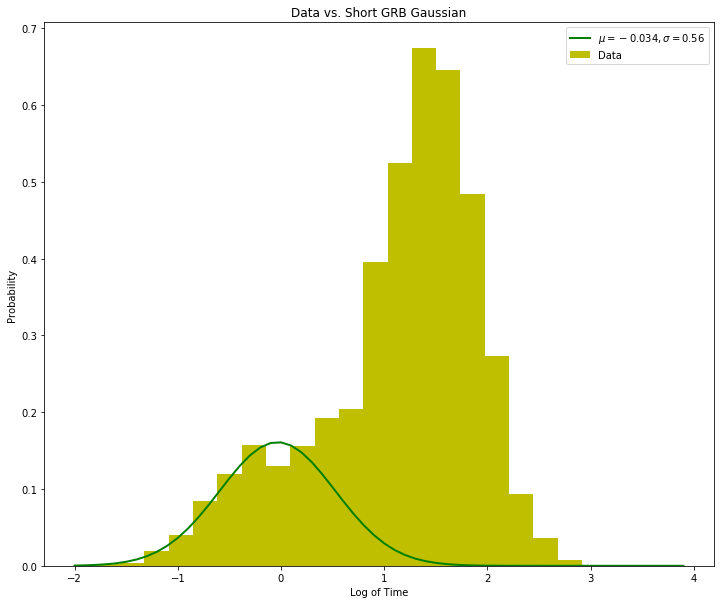

In [31]:
plt.figure(figsize = (12,10))
plt.plot(theta, w1 * GaussianDist(theta, mu1, sd1), color = 'g', zorder = 10, linewidth = 2)
plt.hist(logT90, bins = 20, color = 'y', density = True);
plt.xlabel('Log of Time');
plt.ylabel('Probability');
plt.title('Data vs. Short GRB Gaussian');
plt.legend(["$\mu = {}, \sigma = {}$".format(float(str(mu1)[:6]), float(str(sd1)[:5])), 'Data']);

#### From the posterior estimates we can see that the percent of short GRBs is 23% +/- 4%. We can say this with a relatively high cartainty due to the small standard deviations on the variables, a well fitting model, and how different the two weights are.

Finally, lets determine the class of some specific GRBs.  For this you will need to build a new model with latent variables for the subpopulation type of each GRB.

What is the most likely GRB type for `GRB110717180`?  How certain is this association?  What about `GRB080808451`?

In [32]:
# Posterior estimates for associations of specific GRBs (5/5)

In [33]:
index = []
i = 0
while(i < len(logT90)):
    #print(i)
    if data['name'][i] == b'GRB110717180' or data['name'][i] == b'GRB080808451':
        index.append(i)
    i += 1
for i in index:
    print(logT90[i])

0.6386888866901235
-0.9507819773298184


In [34]:
shortGRBprob = w1 * GaussianDist(logT90[index], mu1, sd1)
longGRBprob = w2 * GaussianDist(logT90[index], mu2, sd2)
GRBsum = shortGRBprob + longGRBprob
s = shortGRBprob / GRBsum 
l = longGRBprob / GRBsum
print('Theres a {:.5f}% chance that GRB110717180 is a short GRB'.format(100 * s[0]))
print('Theres a {:.5f}% chance that GRB110717180 is a long GRB'.format(100 * l[0]))
print('Theres a {:.5f}% chance that GRB080808451 is a short GRB'.format(100 * s[1]))
print('Theres a  {:.5f}% chance that GRB080808451 is a long GRB'.format(100 * l[1]))


Theres a 37.89498% chance that GRB110717180 is a short GRB
Theres a 62.10502% chance that GRB110717180 is a long GRB
Theres a 99.99920% chance that GRB080808451 is a short GRB
Theres a  0.00080% chance that GRB080808451 is a long GRB


#### So this model runs, albeit slow, and outputs what I want but I'm not sure how to extract the category information of the GRBs we want to know so I did probablity proportions above using the two gaussians that the previous model found. 

In [35]:
k = 2

with pm.Model() as MixCat:
    # weights
    w = pm.Dirichlet('w', a = np.ones(k), shape = k, testval = [0.5, 0.5])

    # means
    means = pm.Uniform('means', min(logT90), max(logT90), shape = k, testval = [0.5, 1.5])

    # subpopulation standard deviations
    sd = pm.Exponential('sd', 1, shape = k, testval = [1, 1])
    
    # avoid the exchange symmetry to make sampling easier
    if k > 1:
        switchs = [pm.math.switch(means[c] - means[c-1] < 0, -np.inf, 0) for c in range(1, k)]
        order_means_potential = pm.Potential('order_means_potential', pm.math.sum(switchs))
        
    category = pm.Categorical('category', p=w, shape=len(logT90))
 
    mixture = pm.Normal('obs', mu = means[category], sd = sd[category], observed = logT90)

In [36]:
with MixCat:
    trace = pm.backends.ndarray.NDArray(name = 'Trace', vars = [category])
    start = pm.find_MAP()
    trace3 = pm.sample(1000, start=start, tune = 100, trace = trace)

logp = -2,599.9, ||grad|| = 10.424: 100%|██████████| 30/30 [00:00<00:00, 232.24it/s]  
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sd, means, w]
>BinaryGibbsMetropolis: [category]
Sampling chain 0, 0 divergences:  29%|██▉       | 322/1100 [06:18<15:15,  1.18s/it] 
The acceptance probability does not match the target. It is 0.9068923858686971, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [37]:
pm.traceplot(trace3, ['w', 'sd', 'means']);
pm.autocorrplot(trace3, ['w', 'sd', 'means']);

/opt/conda/lib/python3.7/site-packages/arviz/data/io_pymc3.py:218: UserWarning: Could not compute log_likelihood, it will be omitted.
                Check your model object or set log_likelihood=False
  Check your model object or set log_likelihood=False"""


KeyError: "['w' 'sd' 'means'] var names are not present in dataset"

## 581 students: Just 2 components? (0/20)

Is a two-component model the best descriptor of the data?  Convince me.